In [29]:
# import libraries 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor,AdaBoostRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error

# 0. Read data

In [4]:
df = pd.read_csv('../data/spotify_clean_reg.csv')
df_outliers = pd.read_csv('../data/spotify_clean_reg_without_outliers.csv')

In [5]:
df.head()

,Unnamed: 0,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,duration_s
0,0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,0.910,0.000,C#,0.3460,-1.828,Major,0.0525,166.969,4/4,0.814,99.373
1,1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.246,0.590,0.737,0.000,F#,0.1510,-5.559,Minor,0.0868,174.003,4/4,0.816,137.373
2,2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.952,0.663,0.131,0.000,C,0.1030,-13.879,Minor,0.0362,99.488,5/4,0.368,170.267
3,3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.703,0.240,0.326,0.000,C#,0.0985,-12.178,Major,0.0395,171.758,4/4,0.227,152.427
4,4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.950,0.331,0.225,0.123,F,0.2020,-21.150,Major,0.0456,140.576,4/4,0.390,82.625


In [6]:
df = df.drop(columns=['Unnamed: 0'])
df_outliers = df_outliers.drop(columns=['Unnamed: 0'])

### 1. Drop the useless columns

In [7]:
df_1 = df.drop(columns=['genre', 'artist_name', 'track_name', 'track_id'])
df_out_1 = df_outliers.drop(columns=['genre', 'artist_name', 'track_name', 'track_id'])

### 2. Transform to dummy

In [36]:
df_trans=df_1.drop(columns=['key','time_signature', 'mode'])

In [8]:
#df_trans = pd.get_dummies(df_1, columns=['key','time_signature', 'mode'])
#df_trans_out = pd.get_dummies(df_out_1, columns=['key','time_signature', 'mode'])

In [37]:
df_numerical_col = df_trans.select_dtypes(include=['int64', 'float64'])

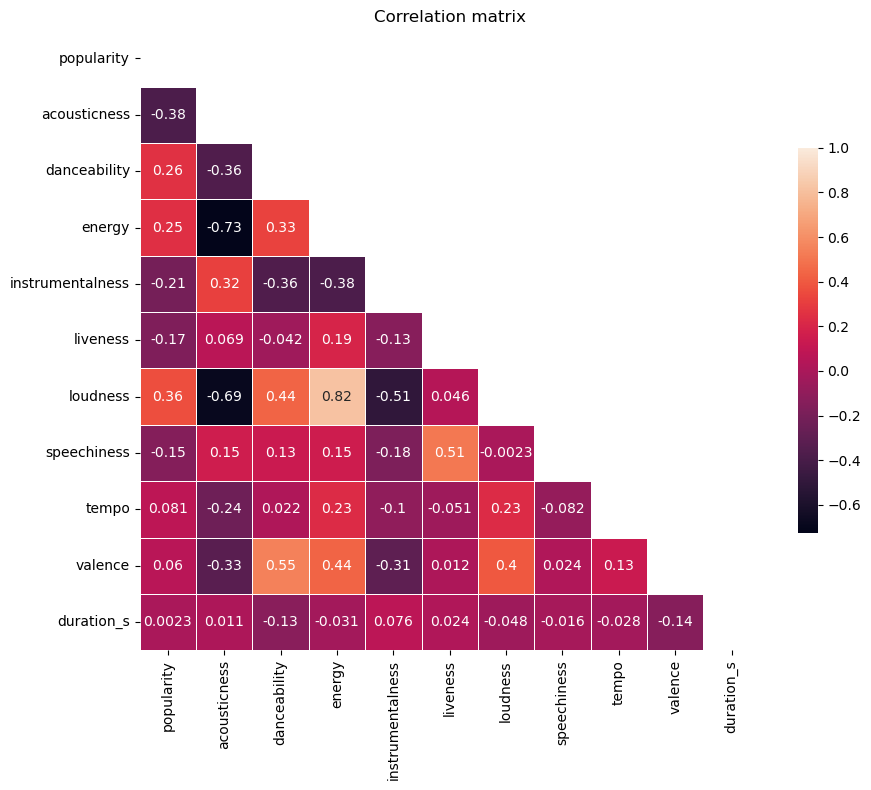

In [38]:
#Correlation matrix
corr=df_numerical_col.corr()
#Set up mask for triangle representation
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 10))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,  vmax=1,square=True, linewidths=.5, cbar_kws={"shrink": .5},annot = corr)
plt.title('Correlation matrix')
plt.show()

In [39]:
#Remove the less correlated features and key, time_signature and mode columns
df_trans=df_trans.drop(columns=["duration_s", "valence","tempo"])

### 3. Perform Train Test Split

In [40]:
features = df_trans.drop(columns=["popularity"], axis = 1)
target = df_trans["popularity"]
features_out = df_trans_out.drop(columns=["popularity"], axis = 1)
target_out = df_trans_out["popularity"]

In [41]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=0)

In [42]:
X_train_out, X_test_out, y_train_out, y_test_out = train_test_split(features_out, target_out, test_size=0.20, random_state=0)

#### 3.1 Normalization

In [43]:
normalizer = MinMaxScaler()

In [44]:
#Fit to our training data
normalizer.fit(X_train)

MinMaxScaler()

In [45]:
X_train_norm = normalizer.transform(X_train)

X_test_norm = normalizer.transform(X_test)

In [46]:
X_train_norm = pd.DataFrame(X_train_norm, columns = X_train.columns)
X_train_norm.head()

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness
0,0.983936,0.297286,0.221205,0.003994,0.113427,0.622373,0.078596
1,0.848394,0.650252,0.326313,0.301301,0.102319,0.738652,0.045609
2,0.877510,0.629868,0.433422,0.000000,0.869740,0.683404,0.975605
3,0.557229,0.620212,0.691685,0.000000,0.088183,0.846871,0.250106
4,0.005070,0.479670,0.926925,0.011512,0.870750,0.829362,0.029593


In [47]:
X_test_norm = pd.DataFrame(X_test_norm, columns = X_test.columns)
X_test_norm.head()

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness
0,0.007952,0.862676,0.605598,0.269269,0.046278,0.753599,0.128129
1,0.260040,0.818689,0.372360,0.000000,0.079095,0.718350,0.069156
2,0.198795,0.787576,0.575567,0.000006,0.073743,0.716891,0.056428
3,0.960843,0.433537,0.060942,0.000000,0.105349,0.416896,0.061095
4,0.985944,0.333762,0.382370,0.010511,0.317399,0.684739,0.080717


### 4. Model Selection

#### 4.1 k-NN

In [48]:
number_of_neighbours = 80

In [49]:
knn = KNeighborsRegressor(n_neighbors=number_of_neighbours)

In [50]:
knn.fit(X_train_norm, y_train)

KNeighborsRegressor(n_neighbors=80)

In [51]:
knn.score(X_test_norm, y_test)

0.2941155350718774

In [ ]:
l = []
for i in range(10,50):
    
    knn = KNeighborsRegressor(n_neighbors=i)
    knn.fit(X_train_norm, y_train)
    r2 = knn.score(X_test_norm, y_test)
    l.append(r2)
    
    
    print(f"k = {i}  || R^2 = {r2}")

k = 10  || R^2 = 0.21286849362825522
k = 11  || R^2 = 0.21337499716190056
k = 12  || R^2 = 0.2145943657851086
k = 13  || R^2 = 0.2168802377387442
k = 14  || R^2 = 0.21767247827051805
k = 15  || R^2 = 0.2180809532958955
k = 16  || R^2 = 0.21852908303789564
k = 17  || R^2 = 0.21960517631842336
k = 18  || R^2 = 0.2204747775193785
k = 19  || R^2 = 0.22185182671363302
k = 20  || R^2 = 0.2223647376574288


KeyboardInterrupt: 

Bagging and pasting model

In [52]:
#Bagging Regressor
bagging_reg = BaggingRegressor(DecisionTreeRegressor(max_depth=20),
                               n_estimators=100,
                               max_samples = 1000)

In [53]:
#Training Bagging model with our normalized data
bagging_reg.fit(X_train_norm, y_train)

BaggingRegressor(estimator=DecisionTreeRegressor(max_depth=20),
                 max_samples=1000, n_estimators=100)

In [54]:
#Evaluation of Bagging regressor
pred = bagging_reg.predict(X_test_norm)

print("MAE", mean_absolute_error(pred, y_test))
print("RMSE", root_mean_squared_error(pred, y_test))
print("R2 score", bagging_reg.score(X_test_norm, y_test))

MAE 12.016350848048377
RMSE 15.312854937436963
R2 score 0.29861561492908917


Random Forest

In [55]:
#Inicialize Random Forest Regressor
forest = RandomForestRegressor(n_estimators=100,
                             max_depth=20)

In [56]:
#Training the model
forest.fit(X_train_norm, y_train)

RandomForestRegressor(max_depth=20)

In [ ]:
#Evaluate Random Forest Regressor
pred = forest.predict(X_test_norm)

print("MAE", mean_absolute_error(pred, y_test))
print("RMSE", root_mean_squared_error(pred, y_test))
print("R2 score", forest.score(X_test_norm, y_test))

Gradient Boosting

In [ ]:
#Inicialize AdaBoost Regressor
gb_reg = GradientBoostingRegressor(max_depth=20,
                                   n_estimators=100)

In [ ]:
#Training the model
gb_reg.fit(X_train_norm, y_train)

In [ ]:
#Evaluation of AdaBoost Regressor
pred = gb_reg.predict(X_test_norm)

print("MAE", mean_absolute_error(pred, y_test))
print("RMSE", root_mean_squared_error(pred, y_test))
print("R2 score", gb_reg.score(X_test_norm, y_test))

In [ ]:
#Evaluation of AdaBoost Regressor
pred = gb_reg.predict(X_test_norm)

print("MAE", mean_absolute_error(pred, y_test))
print("RMSE", root_mean_squared_error(pred, y_test))
print("R2 score", gb_reg.score(X_test_norm, y_test))

Adaptative Boosting

In [ ]:
ada_reg = AdaBoostRegressor(DecisionTreeRegressor(max_depth=20),
                            n_estimators=100)

In [ ]:
#Training the model
ada_reg.fit(X_train_norm, y_train)

In [ ]:
#Evaluate the model
pred = ada_reg.predict(X_test_norm)

print("MAE", mean_absolute_error(pred, y_test))
print("RMSE", root_mean_squared_error(pred, y_test))
print("R2 score", ada_reg.score(X_test_norm, y_test))

XGBoost Regressor

In [ ]:
#Inicialize XGBoost Regressor
from xgboost import XGBRegressor

In [ ]:
# Instantiate the XGBoost Regressor
xgb_model = XGBRegressor(n_estimators=1000, random_state=42, n_jobs=-1)

# Train the model
xgb_model.fit(X_train, y_train)

In [ ]:
# Evaluate the model
pred = xgb_model.predict(X_test)

print("MAE:", mean_absolute_error(y_test, pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, pred)))
print("R2 score:", xgb_model.score(X_test, y_test))